In [21]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.nn import Parameter
from torch.nn.modules.module import Module
import numpy as np
import matplotlib.pyplot as plt


In [22]:
k_bits = 8
m = 2**k_bits
n_channels = 8
batch_size = 256
batch_size_2 = 512
batch_size_3 = 1024
# s_onehot = nn.Parameter(torch.zeros(1, n_channels, m))
indices = torch.randint(0, m, (batch_size,))
    
# Tạo one-hot encoding
s_onehot = torch.zeros(batch_size, m)
s_onehot.scatter_(1, indices.unsqueeze(1), 1)
s_onehot.size()  # (batch_size, m)


torch.Size([256, 256])

In [23]:
def Create_data(m, batch_size):
    data = torch.randint(0, m, (batch_size,))
    
    onehot_data = torch.zeros(batch_size, m)
    
    for i in range(batch_size):
        onehot_data[i].scatter_(0, data[i].unsqueeze(0), 1)  
    return onehot_data

data = Create_data(m, batch_size)
print("Data shape:", data.size())  # Should print: (batch_size, m)


Data shape: torch.Size([256, 256])


In [24]:
class AWGNChannel(nn.Module):
    def __init__(self):
        super(AWGNChannel, self).__init__()
        
    def forward(self, x, noise_std):
        # Generate Gaussian noise
        noise = torch.randn_like(x) * noise_std
        # Add noise to input
        return x + noise

In [44]:
class AutoEncoder  (nn.Module) : 
    def __init__(self, n_channels, k_bits):
        super(AutoEncoder, self).__init__()
        self.n_channels = n_channels
        self.k_bits = k_bits
        self.m = 2**k_bits
        hidden_layer = int(self.m // 2)
        self.encoder_Transmmitter = nn.Sequential(
            nn.Linear(m ,m ),
            nn.BatchNorm1d(m),
            nn.ReLU(),

            nn.Linear(m , hidden_layer),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_layer ,n_channels),
            nn.BatchNorm1d(n_channels)
        )
        self.decoder_Receiver = nn.Sequential(
            nn.Linear(n_channels, hidden_layer),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),

            nn.Linear(hidden_layer , m),
            nn.BatchNorm1d(m),
            nn.ReLU(),            
            nn.Linear(m ,m )
        )
        self.channel = AWGNChannel()
    def forward(self, x):
        x = self.encoder_Transmmitter(x)
        x = x / torch.sqrt(torch.mean(torch.square(x)))
        x= self.channel(x, noise_std=0.1)
        x = self.decoder_Receiver(x)
        return x

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

model = AutoEncoder(n_channels, k_bits).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()



Using CPU


In [ ]:
# 1. Thêm learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=10,
    verbose=True
)

nums_epochs = 300
best_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(nums_epochs):
    # Training
    model.train()
    train_loss = 0.0
    
    for batch_idx in range(0, batch_size, 32):
        batch_data = Create_data(m, 32).to(device)                      
        # batch_indices = torch.randint(0, m, (32,)).to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_data)  # Use batch_data for loss calculation
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss = train_loss / (batch_size / 32)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_data = Create_data(m, 128).to(device)  # Larger validation batch
        # val_indices = torch.randint(0, m, (128,)).to(device)
        val_outputs = model(val_data)
        val_loss = criterion(val_outputs,val_data).item()
    val_losses.append(val_loss)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{nums_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Save best model based on validation loss
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_model.pth')

Epoch [1/300]
Train Loss: 0.1265, Val Loss: 0.0164
Epoch [2/300]
Train Loss: 0.0902, Val Loss: 0.0289
Epoch [3/300]
Train Loss: 0.0760, Val Loss: 0.0423
Epoch [4/300]
Train Loss: 0.0669, Val Loss: 0.0513
Epoch [5/300]
Train Loss: 0.0614, Val Loss: 0.0556
Epoch [6/300]
Train Loss: 0.0562, Val Loss: 0.0527
Epoch [7/300]
Train Loss: 0.0520, Val Loss: 0.0494
Epoch [8/300]
Train Loss: 0.0489, Val Loss: 0.0437
Epoch [9/300]
Train Loss: 0.0457, Val Loss: 0.0395
Epoch [10/300]
Train Loss: 0.0434, Val Loss: 0.0378
Epoch [11/300]
Train Loss: 0.0416, Val Loss: 0.0359
Epoch [12/300]
Train Loss: 0.0399, Val Loss: 0.0334
Epoch [13/300]
Train Loss: 0.0380, Val Loss: 0.0333
Epoch [14/300]
Train Loss: 0.0373, Val Loss: 0.0311
Epoch [15/300]
Train Loss: 0.0372, Val Loss: 0.0324
Epoch [16/300]
Train Loss: 0.0364, Val Loss: 0.0306
Epoch [17/300]
Train Loss: 0.0356, Val Loss: 0.0301
Epoch [18/300]
Train Loss: 0.0358, Val Loss: 0.0302
Epoch [19/300]
Train Loss: 0.0349, Val Loss: 0.0299
Epoch [20/300]
Train 

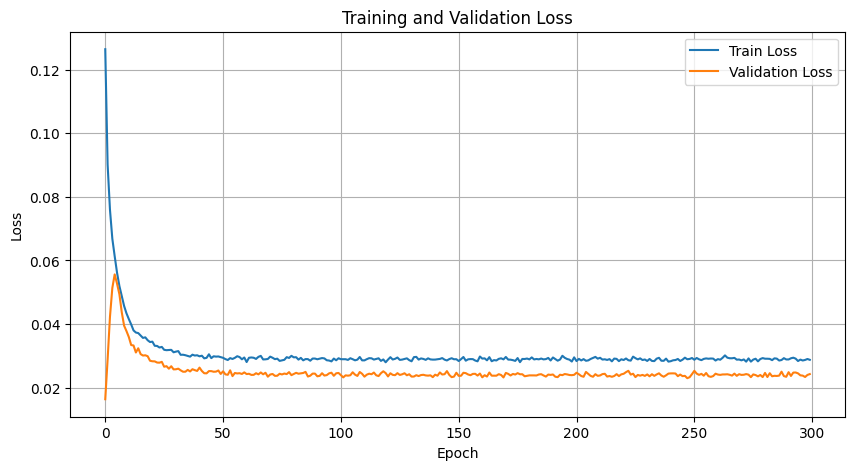

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()